# Data Wrangling

In [1]:
#read data file 

import pandas as pd

oil_df = pd.read_csv('/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/oil.csv')
stores_df = pd.read_csv('/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/stores.csv')
transactions_df = pd.read_csv('/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/transactions.csv')
holidays_events_df = pd.read_csv('/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/holidays_events.csv')
train_df = pd.read_csv('/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/train.csv')

In [2]:
# Preview the first few rows of each dataset to understand their structure
datasets_preview = {
    'holidays_events': holidays_events_df.head(25),
    'oil': oil_df.head(25),
    'stores': stores_df.head(25),
    'train': train_df.head(25),
    'transactions': transactions_df.head(25)
}

datasets_preview

{'holidays_events':           date      type    locale                     locale_name   
 0   2012-03-02   Holiday     Local                           Manta  \
 1   2012-04-01   Holiday  Regional                        Cotopaxi   
 2   2012-04-12   Holiday     Local                          Cuenca   
 3   2012-04-14   Holiday     Local                        Libertad   
 4   2012-04-21   Holiday     Local                        Riobamba   
 5   2012-05-12   Holiday     Local                            Puyo   
 6   2012-06-23   Holiday     Local                        Guaranda   
 7   2012-06-25   Holiday  Regional                        Imbabura   
 8   2012-06-25   Holiday     Local                       Latacunga   
 9   2012-06-25   Holiday     Local                         Machala   
 10  2012-07-03   Holiday     Local                   Santo Domingo   
 11  2012-07-03   Holiday     Local                       El Carmen   
 12  2012-07-23   Holiday     Local                       

(a) Dimensions

Time: All datasets contain a date field, representing the time dimension.

Geography: The stores dataset contains city and state fields, and store_nbr in multiple datasets identifies individual stores.

Product/Service: The train dataset mentions a family field, indicating product categories.

External Factors:
Holidays Events: Captured in holidays_events.csv, detailing types and locales of events.
Oil Prices: Provided in oil.csv, which could be an external economic factor.

(b) Number of Time Series

For each store, there are 33 time series corresponding to all products sold in one store.

There are totally 54 stores across different cities and states. Each store can also be categorized in different types or clusters.

The oil price is a time series dataset common for all stores. 

The holidays_events is a time series dataset with specific holidays for each location. These two are exogenous variables. 

(c) The total number of unique time series would be a combination of the number of stores, product categories within each store, and external factors like holidays/events and oil prices affecting them. There are totally 3564 time series.

(d) Target and Exogenous Variables

Target: In the train.csv dataset, the sales column represents the target variable, which is non-categorical (continuous).

Exogenous Variables:

On Promotion (onpromotion): Indicates if products were on promotion, which is a non-categorical (binary/integer) feature in train.csv.

Oil Prices (dcoilwtico): A continuous variable that can influence sales.

Holidays/Events: Categorical variables indicating the type of holiday event.


(f) Resolution of Time Series

Given the datasets contain daily records, the inherent resolution of the time series is daily.

(g) Project Resolution and Forecasting Horizon

Resolution for the Project: Depending on the business problem, the daily resolution could be maintained for short-term forecasting or aggregated to weekly/monthly for longer-term outlooks.

Forecasting Horizon: This should be defined based on the client's needs. For a daily resolution, it could range from a few days to weeks; for a monthly aggregation, the horizon could extend to several months or a year.

In summary, the project encompasses multiple dimensions, including time, geography, product categories, and external factors. The target variable is sales, and there are numerous exogenous variables across the datasets. The inherent time series resolution is daily, but the project's resolution and forecasting horizon should be tailored to specific business objectives.

In [31]:
%store oil_df stores_df transactions_df holidays_events_df train_df

Stored 'oil_df' (DataFrame)
Stored 'stores_df' (DataFrame)
Stored 'transactions_df' (DataFrame)
Stored 'holidays_events_df' (DataFrame)
Stored 'train_df' (DataFrame)


# EDA

In [32]:
%store -r oil_df stores_df transactions_df holidays_events_df train_df

In [3]:
#Check the missing data and missing date in train.csv
#import pandas and load the dataset
import pandas as pd


# Check for missing values
missing_values = train_df.isnull().sum()

# Check for time gaps by converting the date column to datetime and then identifying any missing dates
train_df['date'] = pd.to_datetime(train_df['date'])
date_range = pd.date_range(start=train_df['date'].min(), end=train_df['date'].max())
missing_dates = date_range.difference(train_df['date'])

missing_values_summary = {
    "Missing Values": missing_values,
    "Number of Missing Dates": len(missing_dates),
    "Missing Dates": missing_dates
}

missing_values_summary


{'Missing Values': id             0
 date           0
 store_nbr      0
 family         0
 sales          0
 onpromotion    0
 dtype: int64,
 'Number of Missing Dates': 4,
 'Missing Dates': DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)}

In [15]:
#fill in missing data and missing date in train.csv
# Ensure 'date' is a datetime type
train_df['date'] = pd.to_datetime(train_df['date'])


# Create a date range that covers all dates in dataset
full_date_range = pd.date_range(start=train_df['date'].min(), end=train_df['date'].max())

# Generate a complete MultiIndex covering every combination of store, date, and family
all_combinations = pd.MultiIndex.from_product([train_df['store_nbr'].unique(), full_date_range, train_df['family'].unique()], names=['store_nbr', 'date', 'family'])

# Reindex dataframe to this complete set, filling missing observations with 0 (or appropriate defaults)
train_df.set_index(['store_nbr', 'date', 'family'], inplace=True)
train_df = train_df.reindex(all_combinations, fill_value=0).reset_index()

# Now, the dataframe has no missing dates for any store/family combination, with missing data filled in as zeros.

# Example: Save the updated DataFrame to a new CSV file
train_df.to_csv('/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/updated_train.csv', index=False)


In [8]:
# Define the full expected date range for all stores
expected_date_range = pd.date_range(start="2013-01-01", end="2017-08-15")

# Renaming the dataframe from df to transactions_df for clarity
df = transactions_df.copy()

# Initialize a dictionary to hold the result for each store
store_missing_dates = {}

# Iterate through each unique store number to check for missing dates
for store in df['store_nbr'].unique():
    store_df = df[df['store_nbr'] == store]
    store_unique_dates = store_df['date'].unique()
    
    # Find missing dates for each store within the expected date range
    missing_dates = [date for date in expected_date_range if date not in store_unique_dates]
    store_missing_dates[store] = {
        "missing_dates_count": len(missing_dates),
        "missing_dates_example": missing_dates[:3] if len(missing_dates) > 0 else []
    }

# Convert the results to a more readable format (e.g., DataFrame) for summary
missing_summary = pd.DataFrame.from_dict(store_missing_dates, orient='index').reset_index()
missing_summary.rename(columns={"index": "store_nbr"}, inplace=True)

# Overview of missing data summary
missing_data_overview = df.isnull().sum()

missing_summary, missing_data_overview


(    store_nbr  missing_dates_count   
 0          25                   73  \
 1          30                   33   
 2          31                   10   
 3          32                   11   
 4          33                   10   
 5          34                   10   
 6          35                   12   
 7          37                   10   
 8          38                   10   
 9          40                   11   
 10         28                   11   
 11         41                   11   
 12         44                   11   
 13         45                   11   
 14         46                   11   
 15         47                   11   
 16         48                   11   
 17         49                   11   
 18         50                   11   
 19         51                   11   
 20         54                   12   
 21         43                   16   
 22         27                   11   
 23         39                   10   
 24         26           

The transactions of store 53, 20, 29, 21, 42, 22, 52 have at least approximately 1/3 of the date missing. 

In [11]:
import pandas as pd

# Assuming transactions_df is your original DataFrame

# Define the full expected date range for all stores
expected_date_range = pd.date_range(start="2013-01-01", end="2017-08-15")

# Create a new DataFrame to hold the complete data including missing dates filled with 0 transactions
complete_data = []

# Iterate through each store, fill in missing dates, and set transactions to 0 for those dates
for store in transactions_df['store_nbr'].unique():
    store_df = transactions_df[transactions_df['store_nbr'] == store]
    
    # Reindex the store_df to include all dates in the expected range, filling missing values with 0
    store_df_indexed = store_df.set_index('date').reindex(expected_date_range).fillna({'store_nbr': store, 'transactions': 0}).reset_index()
    store_df_indexed.rename(columns={'index': 'date'}, inplace=True)
    
    # Append the results to the complete_data list
    complete_data.append(store_df_indexed)

# Concatenate all the store dataframes back into one dataframe
complete_transactions_df = pd.concat(complete_data)

# Ensure the 'store_nbr' column is of integer type
complete_transactions_df['store_nbr'] = complete_transactions_df['store_nbr'].astype(int)

# Save the new dataframe with complete data to a new CSV file
complete_transactions_df.to_csv('/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/transactions_updated.csv', index=False)

transactions_df = complete_transactions_df.copy()

In [5]:
# #check missing data and date in transactions dataset

# missing_values = transactions_df.isnull().sum()
# print("Missing values in each column:")
# print(missing_values)


# # Convert the 'date' column to datetime
# transactions_df['date'] = pd.to_datetime(transactions_df['date'])

# # Sort the data by date
# transactions_df = transactions_df.sort_values('date')

# # Create a full range of dates from the start to the end
# full_date_range = pd.date_range(start=transactions_df['date'].min(), end=transactions_df['date'].max(), freq='D')

# # Check if all dates in the range are present in the data
# missing_dates = full_date_range.difference(transactions_df['date'])

# # Display missing dates
# print("Missing dates:")
# print(missing_dates)

Missing values in each column:
date            0
store_nbr       0
transactions    0
dtype: int64
Missing dates:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-01-01',
               '2016-01-03', '2016-12-25'],
              dtype='datetime64[ns]', freq=None)


In [12]:
# #fill in missing information for transactions dataset
# # Check if all dates in the range are present in the data
# existing_dates = transactions_df['date'].unique()
# missing_dates = full_date_range.difference(existing_dates)

# # Prepare DataFrame for missing dates
# missing_dates_df_list = []

# for missing_date in missing_dates:
#     for store_nbr in range(1, 55):  # Store numbers from 1 to 54
#         missing_dates_df_list.append({
#             'date': missing_date,
#             'store_nbr': store_nbr,
#             'transactions': 0  # Assuming 0 transactions for missing dates
#         })

# # Convert the list of dicts to DataFrame
# missing_dates_df = pd.DataFrame(missing_dates_df_list)

# # Append missing dates DataFrame to the original transactions DataFrame
# transactions_df = pd.concat([transactions_df, missing_dates_df])

# # Convert the date column to datetime and sort the DataFrame
# transactions_df['date'] = pd.to_datetime(transactions_df['date'])
# transactions_df = transactions_df.sort_values(by=['date', 'store_nbr'])

# # Reset the index of the DataFrame
# transactions_df.reset_index(drop=True, inplace=True)

# # Save the updated transactions DataFrame to a new CSV file
# transactions_df.to_csv('/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/transactions_updated.csv', index=False)

# # Display the updated DataFrame
# transactions_df[transactions_df['date']=='2013-12-25']


In [13]:
#Split one transaction file into 54 stores transactions files


# Loop through each store number
for store_nbr in range(1, 55):
    # Filter data for the current store
    store_data = transactions_df[transactions_df['store_nbr'] == store_nbr]

    # Sort data by date
    store_data_sorted = store_data.sort_values(by='date')

    # Save to a new CSV file
    store_data_sorted.to_csv(f'store_{store_nbr}_transactions.csv', index=False)


In [16]:
##### check missing data in oil price dataset

missing_values = oil_df.isnull().sum()
print("Missing values in each column:")
print(missing_values)


# Convert the 'date' column to datetime
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Sort the data by date
oil_df = oil_df.sort_values('date')

# Create a full range of dates from the start to the end
full_date_range = pd.date_range(start=oil_df['date'].min(), end=oil_df['date'].max(), freq='D')

# Check if all dates in the range are present in the data
missing_dates = full_date_range.difference(oil_df['date'])

# Display missing dates
print("Missing dates:")
print(missing_dates)


Missing values in each column:
date           0
dcoilwtico    43
dtype: int64
Missing dates:
DatetimeIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
               '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
               '2013-02-02', '2013-02-03',
               ...
               '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
               '2017-08-12', '2017-08-13', '2017-08-19', '2017-08-20',
               '2017-08-26', '2017-08-27'],
              dtype='datetime64[ns]', length=486, freq=None)


In [17]:
#Fill in missing data for oil price dataset using linear method and backfilling

oil_df.set_index('date', inplace=True)

# Apply linear interpolation to fill missing weekday values
oil_df_interpolated = oil_df.interpolate(method='linear')


oil_df_interpolated.bfill(inplace=True)
# Reset the index to make 'date' a column again
oil_df_interpolated.reset_index(inplace=True)

# Save the updated transactions DataFrame to a new CSV file
oil_df_interpolated.to_csv('/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/oil_price_updated.csv', index=False)


# Check the result
print(oil_df_interpolated.head())
print(oil_df_interpolated.tail())

        date  dcoilwtico
0 2013-01-01       93.14
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20
           date  dcoilwtico
1213 2017-08-25       47.65
1214 2017-08-28       46.40
1215 2017-08-29       46.46
1216 2017-08-30       45.96
1217 2017-08-31       47.26


In [18]:
#create individual transaction files for each stores. Each file also includes oil price and holiday_event.


def process_store_group(transactions, oil_price, holidays_data, store_city):
    # Merge with oil price data
    transactions = pd.merge(transactions, oil_price, on='date', how='left')
    
    # Filter for national holidays and holidays in the specific city
    relevant_holidays = holidays_data[(holidays_data['locale'] == 'National') | 
                                      ((holidays_data['locale'] == 'Local') & (holidays_data['locale_name'] == store_city))]
    
    # Merge with holidays data
    combined_with_holidays = pd.merge(transactions, relevant_holidays[['date', 'type']], on='date', how='left')
    combined_with_holidays['holiday'] = combined_with_holidays['type'].apply(lambda x: 'Holiday' if pd.notnull(x) else 'Not Holiday')
    combined_with_holidays.drop('type', axis=1, inplace=True)
    
    return combined_with_holidays

# Load the oil price, holidays data, and stores data
oil_price_path = '/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/oil_price_updated.csv'
holidays_path = '/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/holidays_events.csv'
stores_path = '/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/stores.csv'

oil_price = pd.read_csv(oil_price_path)
holidays_data = pd.read_csv(holidays_path)
stores_data = pd.read_csv(stores_path)

# Convert 'date' columns to datetime
oil_price['date'] = pd.to_datetime(oil_price['date'])
holidays_data['date'] = pd.to_datetime(holidays_data['date'])

# Process each store's transactions
for index, row in stores_data.iterrows():
    store_nbr = row['store_nbr']
    store_city = row['city']
    
    # Assuming transactions files are named like 'store_{store_nbr}_transactions.csv'
    store_file = f'/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/store_{store_nbr}_transactions.csv'  # Update the path format as needed
    transactions = pd.read_csv(store_file)
    transactions['date'] = pd.to_datetime(transactions['date'])
    
    # Process the data for this store
    final_data_for_store = process_store_group(transactions, oil_price, holidays_data, store_city)
    
    # Save the processed data for each store
    output_path = store_file.replace('transactions.csv', 'transactions_final.csv')
    final_data_for_store.to_csv(output_path, index=False)

print("Processing complete for all stores.")


Processing complete for all stores.


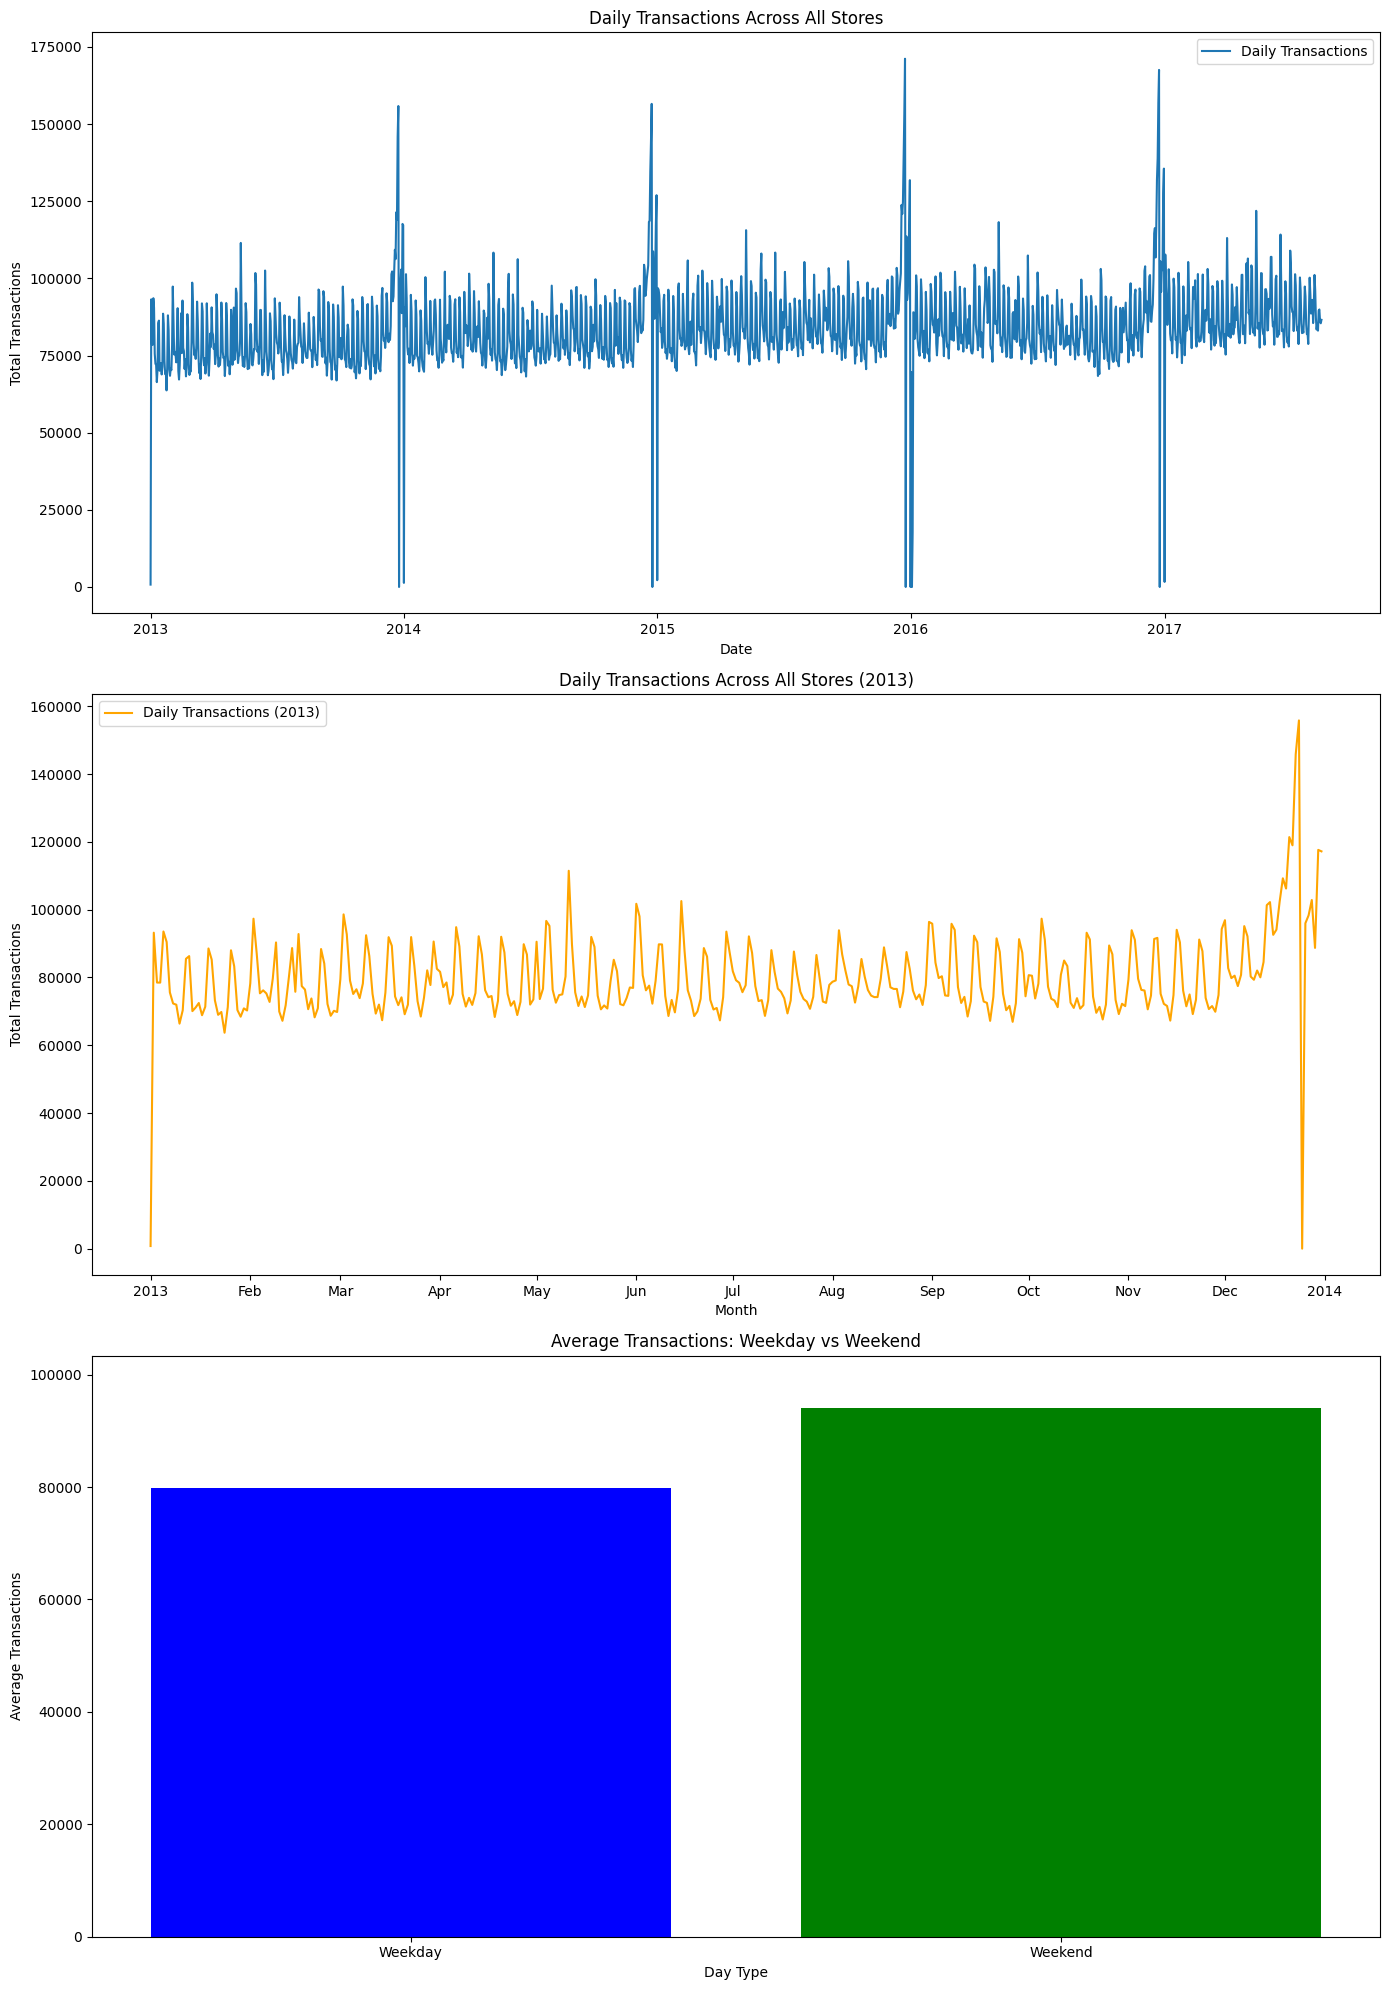

In [21]:
#To show total daily transactions across all stores from year 2013 to 2018
#Zoom in the data in year 2013 to exam the trend, cycle
#Categorize weekday and weekend, compare the average transaction between weekday and weekend 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Convert 'date' to datetime format
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

# Aggregate transactions by date
transactions_by_date = transactions_df.groupby('date')['transactions'].sum().reset_index()



# Assuming transactions_daily_total is already prepared with 'date' as datetime type

# Filtering data for the year 2013
filtered_data_2013 = transactions_by_date[(transactions_by_date['date'] >= '2013-01-01') & 
                                              (transactions_by_date['date'] <= '2013-12-31')]

# Categorizing days as Weekday or Weekend
transactions_by_date['weekday'] = transactions_by_date['date'].dt.dayofweek
transactions_by_date['type'] = np.where(transactions_by_date['weekday'] < 5, 'Weekday', 'Weekend')

# Aggregating transactions by Weekday vs Weekend
weekend_comparison = transactions_by_date.groupby('type')['transactions'].mean().reset_index()

# Setting up the figure and subplots
fig, ax = plt.subplots(3, 1, figsize=(14, 20))

# Full data plot
ax[0].plot(transactions_by_date['date'], transactions_by_date['transactions'], label='Daily Transactions')
ax[0].set_title('Daily Transactions Across All Stores')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Total Transactions')
ax[0].legend()

# 2013 data plot with month information
ax[1].plot(filtered_data_2013['date'], filtered_data_2013['transactions'], label='Daily Transactions (2013)', color='orange')
ax[1].set_title('Daily Transactions Across All Stores (2013)')
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Total Transactions')
ax[1].legend()

# Weekday vs Weekend comparison plot
ax[2].bar(weekend_comparison['type'], weekend_comparison['transactions'], color=['blue', 'green'])
ax[2].set_title('Average Transactions: Weekday vs Weekend')
ax[2].set_xlabel('Day Type')
ax[2].set_ylabel('Average Transactions')
ax[2].set_ylim(0, max(weekend_comparison['transactions']) * 1.1)  # Extend y-limit for visualization

plt.tight_layout()
plt.show()




Transactions across all stores are plot from 2013 to 2017. Clearly peaks appear at each holiday (Thanks's giving to Christmas).

By zooming in 2013, the transactions shows weekly cycle. 

Average weekend transaction is typically higher than weekday.

product sales from high to low family
GROCERY I                     6.133263e+06
BEVERAGES                     3.874187e+06
PRODUCE                       2.191155e+06
CLEANING                      1.741452e+06
DAIRY                         1.151566e+06
BREAD/BAKERY                  7.523919e+05
POULTRY                       5.692144e+05
MEATS                         5.551155e+05
PERSONAL CARE                 4.391438e+05
DELI                          4.305415e+05
HOME CARE                     2.861204e+05
EGGS                          2.783624e+05
FROZEN FOODS                  2.513194e+05
PREPARED FOODS                1.571410e+05
LIQUOR,WINE,BEER              1.383329e+05
SEAFOOD                       3.598986e+04
GROCERY II                    3.504941e+04
HOME AND KITCHEN I            3.324091e+04
HOME AND KITCHEN II           2.715482e+04
CELEBRATION                   1.359245e+04
LINGERIE                      1.166275e+04
LADIESWEAR                    1.162784e+04
PLAYERS AND ELEC

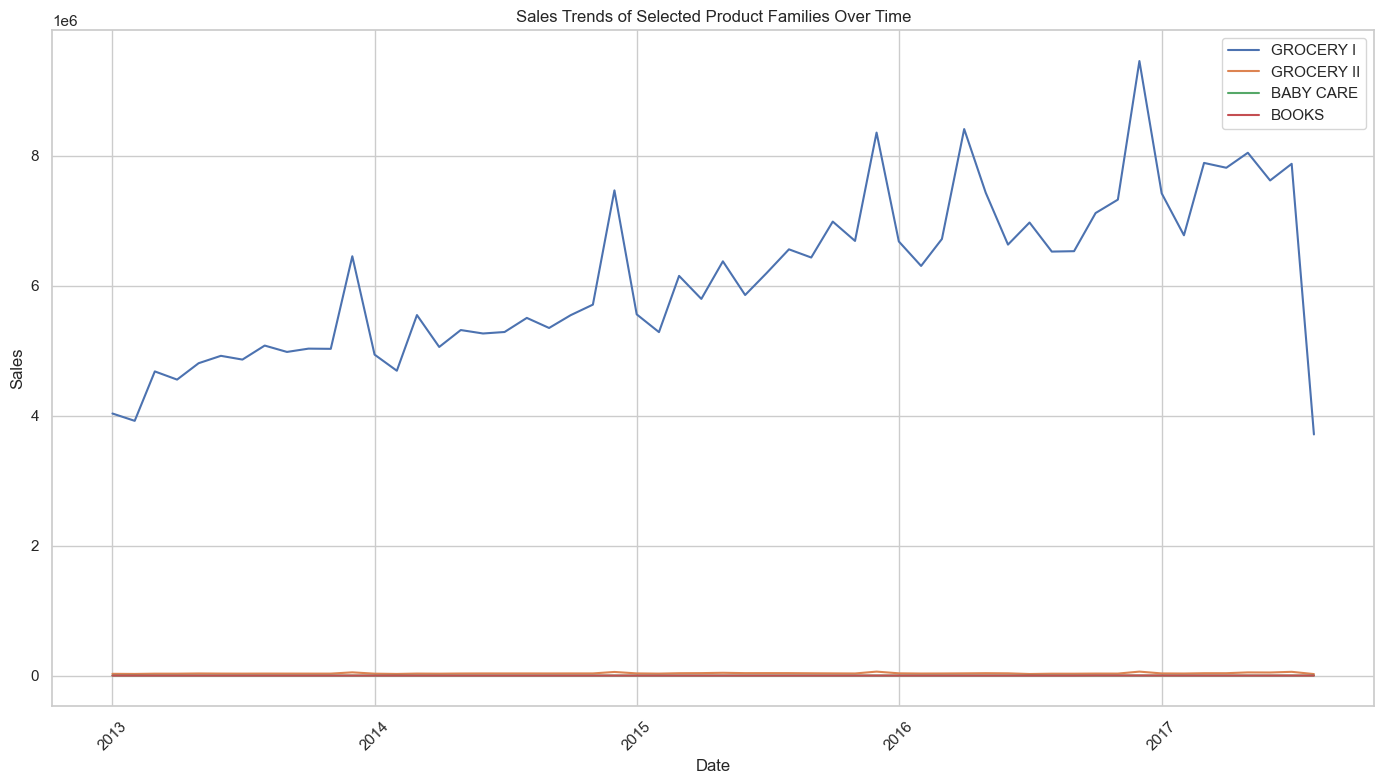

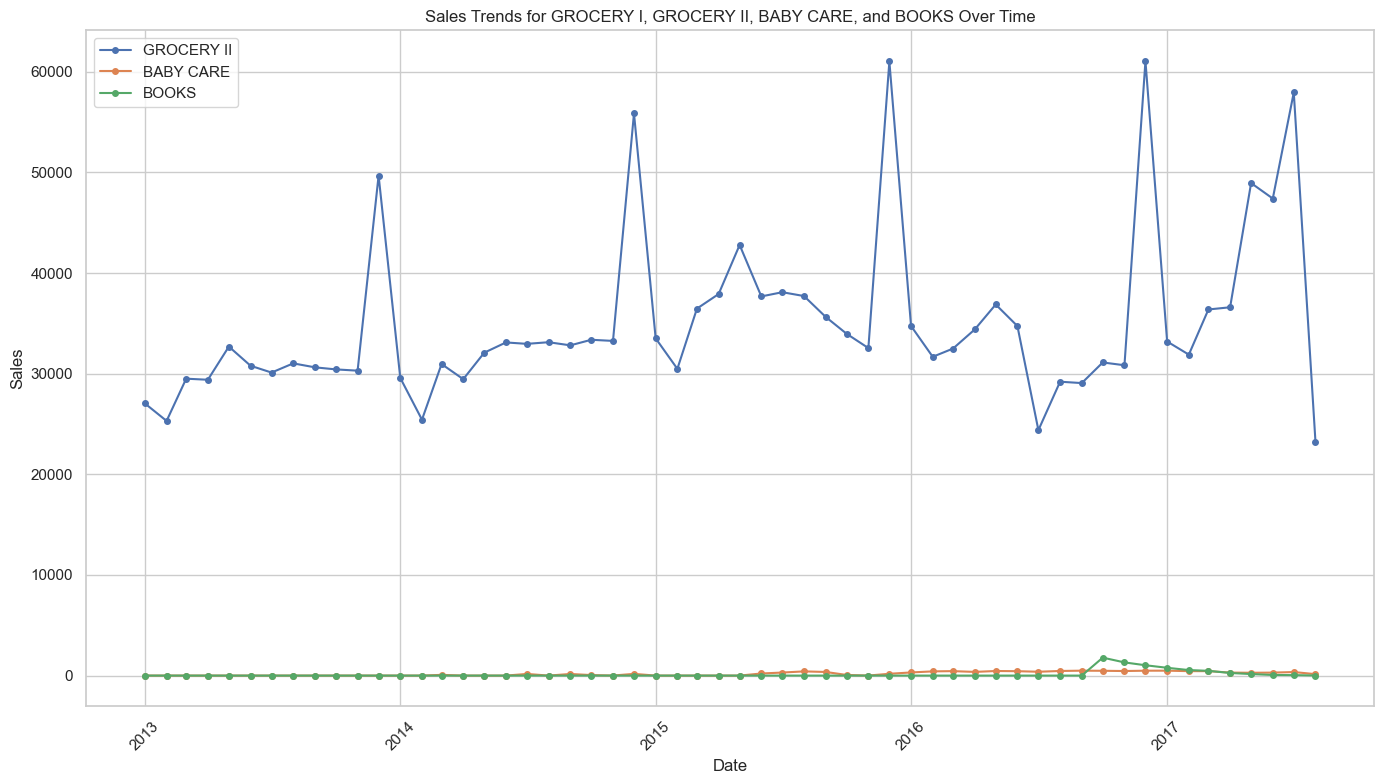

In [32]:
# Calculate average sales for each family to determine the selection

import seaborn as sns

# Group by 'family' and 'date' (month and year), then summarize sales
grouped_sales = train_df.groupby([train_df['date'].dt.to_period('M'), 'family'])['sales'].sum().reset_index()
# Convert 'date' back to datetime format for plotting
grouped_sales['date'] = grouped_sales['date'].dt.to_timestamp()

# Calculate monthly average sales for each family to determine the selection
average_sales_by_family = grouped_sales.groupby('family')['sales'].mean().sort_values(ascending=False)
print('product family sales rank from high to low', average_sales_by_family)

# Selecting families for analysis: one with high sales volume, one with medium, and two with lower/variable
selected_families = average_sales_by_family.head(1).index.tolist() + average_sales_by_family[round(len(average_sales_by_family)/2):round(len(average_sales_by_family)/2)+1].index.tolist() + average_sales_by_family.tail(2).index.tolist()

# Filter the grouped sales data for the selected families
selected_sales_data = grouped_sales[grouped_sales['family'].isin(selected_families)]

# Visualization for Selected Families
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

for family in selected_families:
    family_data = selected_sales_data[selected_sales_data['family'] == family]
    plt.plot(family_data['date'], family_data['sales'], label=family)

plt.title('Sales Trends of Selected Product Families Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Specific Visualization for "GROCERY I", "GROCERY II", "BABY CARE", and "BOOKS"
specific_families = ['GROCERY II', 'BABY CARE', 'BOOKS']
specific_sales_data = selected_sales_data[selected_sales_data['family'].isin(specific_families)]

plt.figure(figsize=(14, 8))

for family in specific_families:
    family_data = specific_sales_data[specific_sales_data['family'] == family]
    plt.plot(family_data['date'], family_data['sales'], label=family, marker='o', linestyle='-', markersize=4)

plt.title('Sales Trends for GROCERY I, GROCERY II, BABY CARE, and BOOKS Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




The product family monthly sales is shown from the highest the lowest, with the Grocery I being the top sales and books the lowest sales. 

Then Grocery I, II, Baby Care and Books are the selected family to show acrosst the time axis.
The visualization above shows the sales trends of the selected product families over time:

GROCERY I exhibits a high sales volume, indicating it's a consistently well-performing product family. The trend might show seasonal peaks or general fluctuations over time.

GROCERY II has a medium sales volume with visible fluctuations, suggesting variability in its performance.

BABY CARE and BOOKS show lower or variable sales volumes. Notably, BABY CARE sales are consistently low (appearing to be zero in this visualization), which might indicate limited transactions or specific data collection issues.

BOOKS also shows low sales, with some variability over time, potentially indicating occasional interest or promotional impacts.

In [36]:
transactions_agg

,date,transactions
0,2013-01-01,770.0
1,2013-01-02,93215.0
2,2013-01-03,78504.0
3,2013-01-04,78494.0
4,2013-01-05,93573.0
...,...,...
1683,2017-08-11,89551.0
1684,2017-08-12,89927.0
1685,2017-08-13,85993.0
1686,2017-08-14,85448.0


In [33]:
#Sum up all sales across all stores and sum up all transactions across all stores on each day

# Convert 'date' in sales data to datetime format
train_df['date'] = pd.to_datetime(train_df['date'])

# Group by 'family' and 'date' (month and year), then summarize sales
grouped_sales = train_df.groupby([train_df['date'].dt.to_period('D'), 'family'])['sales'].sum().reset_index()
# Convert 'date' back to datetime format for plotting
grouped_sales['date'] = grouped_sales['date'].dt.to_timestamp()

# Convert 'date' in transactions data to datetime format
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

# Aggregate transactions data by date
transactions_agg = transactions_df.groupby('date')['transactions'].sum().reset_index()

# Aggregate sales data by date to match the granularity of transactions data
grouped_sales_agg = grouped_sales.groupby('date')['sales'].sum().reset_index()

# Merge the aggregated sales data with the aggregated transactions data on 'date'
sales_transactions_data = pd.merge(grouped_sales_agg, transactions_agg, on='date', how='inner')

# Calculate the correlation between 'sales' and 'transactions'
correlation = sales_transactions_data[['sales', 'transactions']].corr()

print(correlation)


                 sales  transactions
sales         1.000000      0.659377
transactions  0.659377      1.000000


The correlation of 0.66 indicates a major positive relationship between transactions and sales volume, implying that increases in transactions are associated with increases in sales volume, and this association is strong to make accurate predictions based solely on this relationship.

In [45]:
#Since all the stores are across different cities and states, the following code groups all the stores into their cities and states. As all Location: Setting the Scene
#Then the transactions sum up for each city, each state, and each type of the store.
#The transaction amount are ranked from the highest to the lowest. 

# Merge transactions data with stores data on 'store_nbr'
transactions_with_stores = pd.merge(transactions_df, stores_df, on='store_nbr', how='left')

# Aggregate transactions by city, state, and store type
transactions_by_city = transactions_with_stores.groupby(['city'])['transactions'].sum().sort_values(ascending=False)
transactions_by_state = transactions_with_stores.groupby(['state'])['transactions'].sum().sort_values(ascending=False)
transactions_by_type = transactions_with_stores.groupby(['type'])['transactions'].sum().sort_values(ascending=False)

# Display top 5 transactions by city, state, and store type
print("Top 5 Transactions by City:\n", transactions_by_city.head())
print("\nTop 5 Transactions by State:\n", transactions_by_state.head())
print("\nTop 5 Transactions by Store Type:\n", transactions_by_type.head())




Top 5 Transactions by City:
 city
Quito            70999057
Guayaquil        16546295
Ambato            6172615
Cuenca            5673847
Santo Domingo     4655266
Name: transactions, dtype: int64

Top 5 Transactions by State:
 state
Pichincha                         74971545
Guayas                            21894000
Tungurahua                         6172615
Azuay                              5673847
Santo Domingo de los Tsachilas     4655266
Name: transactions, dtype: int64

Top 5 Transactions by Store Type:
 type
D    46230088
A    43215470
C    24788958
B    20384902
E     6859527
Name: transactions, dtype: int64


#Since all the stores are across different cities and states, the following code groups all the stores into their cities and states. As all Location: Setting the Scene
#Then the transactions sum up for each city, each state, and each type of the store.
#The transaction amount are ranked from the highest to the lowest. 

In [46]:
# Sum up product sale in each family
# Rank product famliy sales from the Top 5 and Buttom 5
# Analyze the monthly trend of the Top 5 and Buttom 5 product family sales

# Aggregate sales data by product family to identify top performers and those lagging
sales_by_family = grouped_sales.groupby('family')['sales'].sum().sort_values(ascending=False)

# Identify top 5 performing product families
top_performers = sales_by_family.head(5)

# Identify 5 product families with the lowest sales volumes
lagging_families = sales_by_family.tail(5)

# Analyze seasonal trends by aggregating sales data by product family and month
grouped_sales['month'] = grouped_sales['date'].dt.month
seasonal_sales = grouped_sales.groupby(['family', 'month'])['sales'].mean().unstack()

top_performers, lagging_families, seasonal_sales.loc[top_performers.index], seasonal_sales.loc[lagging_families.index]


(family
 GROCERY I    3.434627e+08
 BEVERAGES    2.169545e+08
 PRODUCE      1.227047e+08
 CLEANING     9.752129e+07
 DAIRY        6.448771e+07
 Name: sales, dtype: float64,
 family
 MAGAZINES          266359.0
 HARDWARE           103470.0
 HOME APPLIANCES     41601.0
 BABY CARE           10051.0
 BOOKS                6438.0
 Name: sales, dtype: float64,
 month                 1              2              3              4    
 family                                                                  
 GROCERY I  184693.398994  191283.683262  199882.907200  210848.476033  \
 BEVERAGES  126912.535484  109317.985816  126926.554839  118582.426667   
 PRODUCE     72855.865666   50856.910387   72016.889815   49326.691692   
 CLEANING    57644.206452   57306.078014   57533.432258   58048.913333   
 DAIRY       36924.309677   36622.929078   39196.748387   38855.866667   
 
 month                 5              6              7              8    
 family                                           


To identify the top-performing product families and those lagging, as well as to understand how seasonal trends affect different product families, we can analyze the sales data focusing on:

Sales Volume: Identify top-performing and lagging product families based on their total sales volume or average sales over the available time period. Seasonal Trends: Examine how sales for different product families vary across different months or quarters to identify any seasonal patterns.

The top-performing product families based on total sales volume are:

GROCERY I BEVERAGES PRODUCE CLEANING DAIRY These families demonstrate strong sales, indicating high demand and possibly broad consumer appeal across various markets.

Lagging Product Families The product families with the lowest sales volumes are:

MAGAZINES HARDWARE HOME APPLIANCES BABY CARE BOOKS These categories show significantly lower sales, which could suggest niche markets, lower demand, or less frequent purchase cycles.

Seasonal Trends for Top Performers The seasonal trends for the top performers indicate variability in sales across different months, with notable increases in certain periods. For example:

GROCERY I and BEVERAGES show significant sales increases in December, suggesting holiday or end-of-year effects. 

PRODUCE sees a notable peak in July, which might correspond to seasonal availability or consumption patterns during summer months.

Seasonal Trends for Lagging Families For the lagging product families, there's also variability, though the scale of sales is much smaller. For instance:

MAGAZINES and BOOKS experience their highest sales towards the end of the year, possibly influenced by gift-giving seasons. 

HOME APPLIANCES show a peak in March, which might align with specific sales promotions or seasonal purchasing behaviors.

In [37]:
# Calculate the correlation between oil price and sales
# Calculate the correlation between oil price and transctions


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Load datasets
sales_file_path = '/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/updated_train.csv'
transactions_file_path = '/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/transactions_updated.csv'
oil_file_path = '/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/oil_price_updated.csv'
holidays_events_file_path = '/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/holidays_events.csv'

sales_data = pd.read_csv(sales_file_path)
transactions_data = pd.read_csv(transactions_file_path)
oil_data = pd.read_csv(oil_file_path)
holidays_events_data = pd.read_csv(holidays_events_file_path)

# Preprocess and aggregate data
sales_data['date'] = pd.to_datetime(sales_data['date'])
transactions_data['date'] = pd.to_datetime(transactions_data['date'])
grouped_sales_agg = sales_data.groupby('date')['sales'].sum().reset_index()
transactions_agg = transactions_data.groupby('date')['transactions'].sum().reset_index()

# Oil prices analysis
oil_data['date'] = pd.to_datetime(oil_data['date'])
oil_data_filled = oil_data.fillna(method='ffill')
sales_with_oil = pd.merge(grouped_sales_agg, oil_data_filled, on='date', how='left')
transactions_with_oil = pd.merge(transactions_agg, oil_data_filled, on='date', how='left')
sales_oil_correlation = sales_with_oil[['sales', 'dcoilwtico']].corr().iloc[0, 1]
transactions_oil_correlation = transactions_with_oil[['transactions', 'dcoilwtico']].corr().iloc[0, 1]

# Holidays and sales analysis
holidays_events_data['date'] = pd.to_datetime(holidays_events_data['date'])
national_holidays = holidays_events_data[holidays_events_data['locale'] == 'National']
sales_national_holidays = pd.merge(grouped_sales_agg, national_holidays, on='date', how='inner')
average_sales_on_holidays = sales_national_holidays['sales'].mean()
overall_average_sales = grouped_sales_agg['sales'].mean()

# Output the correlation results
print("Correlation between oil prices and sales volume:", sales_oil_correlation)
print("Correlation between oil prices and transactions:", transactions_oil_correlation)

# Output the holiday sales analysis results
print("Average sales on national holidays_events:", average_sales_on_holidays)
print("Overall average sales:", overall_average_sales)



Correlation between oil prices and sales volume: -0.6809840066690376
Correlation between oil prices and transactions: -0.26005972497909063
Average sales on national holidays_events: 722977.5467274112
Overall average sales: 636045.5877980264


Sales Volume: A correlation coefficient of approximately -0.680, indicating a strong negative linear relationship. This suggests that as oil prices increase, sales volume tends to decrease, possibly due to increased logistics costs or reduced consumer spending power. 

Transactions: A correlation coefficient of approximately -0.260, indicating a weak negative linear relationship. This suggests a slight tendency for the number of transactions to decrease as oil prices increase, though the relationship is not as strong as with sales volume.

Insights: The strong negative correlation with sales volume highlights the significant impact of oil price fluctuations on consumer spending and logistics costs, affecting overall sales. The weaker correlation with transactions suggests that while there might be some impact on the number of transactions, it's not as pronounced as the effect on sales volume.

The analysis of sales volumes around national holidays compared to overall sales provides the following insights:

The average sales volume on national holidays is approximately 722977, which is higher than the overall average sales volume of 636045. This indicates a general increase in sales during national holidays.

In [48]:
# List out all stores in each city, state, store type, and cluster

import pandas as pd

# Load the stores.csv file
stores_data = pd.read_csv('/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/stores.csv')  

# Grouping the data by city, state, type, and cluster, and printing store numbers
grouped_by_city = stores_data.groupby('city')['store_nbr'].apply(list)
grouped_by_state = stores_data.groupby('state')['store_nbr'].apply(list)
grouped_by_type = stores_data.groupby('type')['store_nbr'].apply(list)
grouped_by_cluster = stores_data.groupby('cluster')['store_nbr'].apply(list)

print("Stores by City:\n", grouped_by_city)
print("\nStores by State:\n", grouped_by_state)
print("\nStores by Type:\n", grouped_by_type)
print("\nStores by Cluster:\n", grouped_by_cluster)


Stores by City:
 city
Ambato                                                    [23, 50]
Babahoyo                                                      [31]
Cayambe                                                       [11]
Cuenca                                                [37, 39, 42]
Daule                                                         [27]
El Carmen                                                     [54]
Esmeraldas                                                    [43]
Guaranda                                                      [19]
Guayaquil                         [24, 26, 28, 29, 30, 32, 34, 51]
Ibarra                                                        [15]
Latacunga                                                 [12, 13]
Libertad                                                      [36]
Loja                                                          [38]
Machala                                                   [40, 41]
Manta                                   

List out all stores in group for each city, state, store type, and cluster

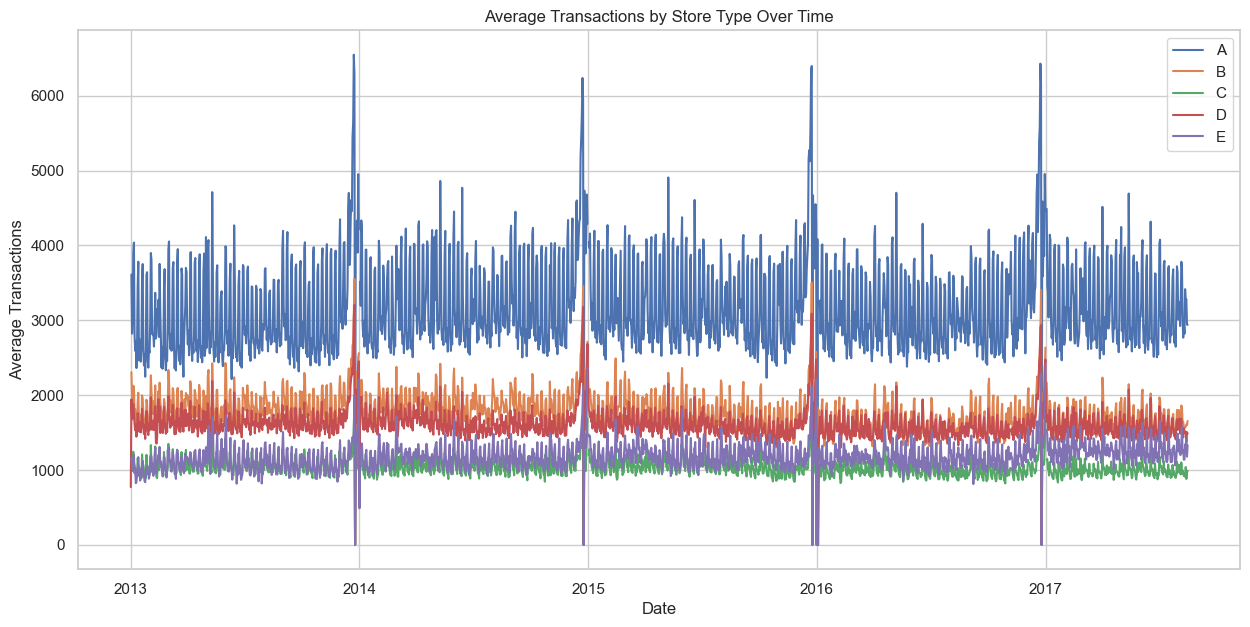

In [49]:
#plot the average transactions for each type of store across year
import matplotlib.pyplot as plt

# Merge transactions with stores on 'store_nbr'
merged_data = pd.merge(transactions_df, stores_data, on='store_nbr')

# Group by date and store type, then calculate the mean
average_transactions = merged_data.groupby(['date', 'type'])['transactions'].mean().reset_index()

# Pivot the data for plotting
pivot_data = average_transactions.pivot(index='date', columns='type', values='transactions')

# Plotting
plt.figure(figsize=(15, 7))
for store_type in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[store_type], label=store_type)

plt.title('Average Transactions by Store Type Over Time')
plt.xlabel('Date')
plt.ylabel('Average Transactions')
plt.legend()
plt.grid(True)
plt.show()

Plot the averate transactions for each type of store from 2013 to 2018. Store type A clearly has the highest average transactions. Type B and D are closed match. Type C and E are clsoed match. 

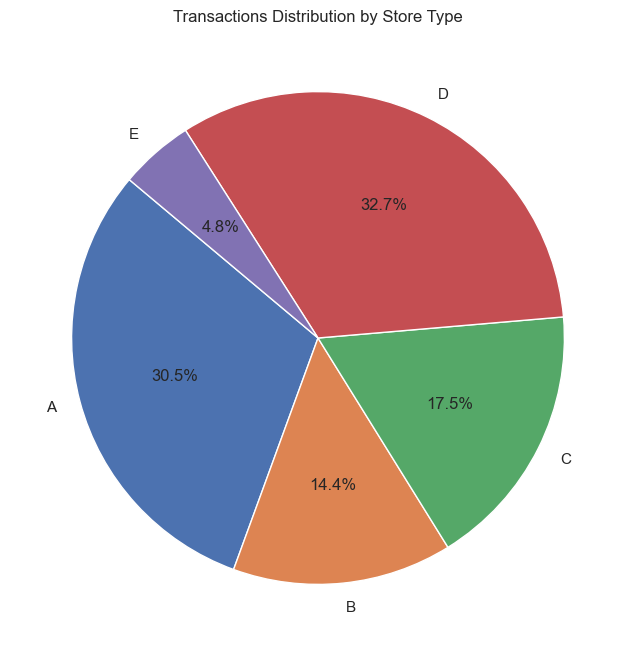

In [50]:
#To plot the percentage of the total transactions of each type of store

import matplotlib.pyplot as plt

# Assuming merged_data is the DataFrame obtained from merging transactions and stores_data
# Group by store type and sum up the transactions
total_transactions_by_type = merged_data.groupby('type')['transactions'].sum()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(total_transactions_by_type, labels=total_transactions_by_type.index, autopct='%1.1f%%', startangle=140)
plt.title('Transactions Distribution by Store Type')
plt.show()


For the total transactions of types of store from A to E, type D store has the highest transactions that accoutns for 32.7% of the total transactions, type A has the second highest transactions 30.5%, and type E has the lowest transactions 4.8%. 

In [28]:
%store oil_df stores_df transactions_df holidays_events_df train_df

Stored 'oil_df' (DataFrame)
Stored 'stores_df' (DataFrame)
Stored 'transactions_df' (DataFrame)
Stored 'holidays_events_df' (DataFrame)
Stored 'train_df' (DataFrame)
